In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot

In [13]:
data = pd.read_csv('../../Data/WeatherOutagesAllJerry.csv')
data = data.dropna(how = 'all')

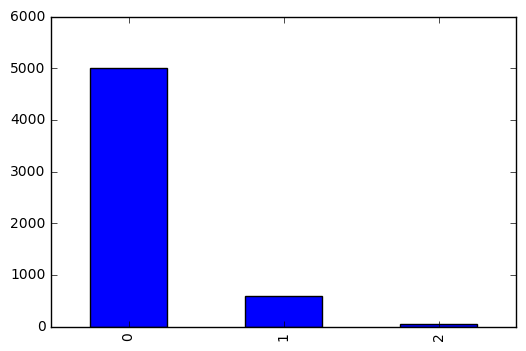

In [14]:
# convert to classification problem
def f(row):
    """function that categories days with more than 8 outages as extreme, 
                                3-8 outages as bad, and 0-2 as normal"""
    if row['Total_outages'] > 8:
        val = 2
    elif row['Total_outages'] > 2:
        val = 1
    else:
        val = 0
    return val

data['category'] = data.apply(f, axis=1)
data.category.value_counts().plot(kind='bar')

In [15]:
train,test=train_test_split(data,test_size=0.1,random_state=567)

In [16]:
x_train = train[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent','Avg_windspeed_mph','Max_windspeed_mph',
                 'Precipitation_in','Event_thunderstorm']]
y_train = train['category']

x_test = test[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent','Avg_windspeed_mph','Max_windspeed_mph',
                 'Precipitation_in','Event_thunderstorm']]
y_test = test['category']

In [17]:
# data normalization
x_train = preprocessing.normalize(x_train)
#y_train = preprocessing.normalize(y_train)
x_test = preprocessing.normalize(x_test)
#y_test = preprocessing.normalize(y_test)

In [18]:
len(y_train[y_train==2])

49

In [19]:
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler 
# Apply the random over-sampling
ros = RandomOverSampler(ratio=0.3,random_state=6)
x_res, y_res = ros.fit_sample(x_train[y_train!=2], y_train[y_train!=2])
ros2 = RandomOverSampler(ratio=0.3,random_state=6)
x_res2, y_res2 = ros2.fit_sample(x_train[y_train!=1], y_train[y_train!=1])

x1 = np.concatenate((x_res,x_res2[y_res2==2]), axis=0)
y1 = np.concatenate((y_res, y_res2[y_res2==2]),axis=0)

In [20]:
x_train = x1
y_train = y1

In [21]:
N_train = x_train.shape[0]
N_test = x_test.shape[0]
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=1000,activation='identity', solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 3), random_state=1)
clf.fit(x_train, y_train)              

MLPClassifier(activation='identity', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [22]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

print("Train error for normalized data",mean_squared_error(y_train,y_train_pred))
print("Test error for normalized data",mean_squared_error(y_test,y_test_pred))

Train error for normalized data 0.500415973378
Test error for normalized data 0.278659611993


In [23]:
df = pd.DataFrame()
#initialize counters 
overall_correctness = 0
under_predict_normal = 0
right_predict_normal = 0
over_predict_normal = 0
under_predict_bad = 0
right_predict_bad = 0
over_predict_bad = 0
under_predict_extreme = 0
right_predict_extreme = 0
over_predict_extreme = 0
    
for index in range(0, N_train):
    if y_train_pred[index] == y_train[index]: # predict correctly
        overall_correctness += 1
        if y_train[index] == 0:
            right_predict_normal += 1
        elif y_train[index] == 1:
            right_predict_bad += 1
        else:
            right_predict_extreme += 1
    elif y_train[index] == 0:
        over_predict_normal += 1
    elif y_train[index] == 1:
        if y_train_pred[index] == 0:
            under_predict_bad += 1
        else:
            over_predict_bad += 1
    else:
        under_predict_extreme += 1
    
df = df.append({"Method": 'NN', "Overall_Correctness": overall_correctness/index,
                    "right_predict_normal": right_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "right_predict_bad": right_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "right_predict_extreme": right_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "under_predict_normal": under_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "under_predict_bad": under_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "under_predict_extreme": under_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "over_predict_normal": over_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "over_predict_bad": over_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "over_predict_extreme": over_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme)},
                  ignore_index=True)
df = df[['Method', 'Overall_Correctness', 'right_predict_normal', 'right_predict_bad','right_predict_extreme',
                              'under_predict_bad','under_predict_extreme',
                              'over_predict_normal','over_predict_bad']]
df      

,Method,Overall_Correctness,right_predict_normal,right_predict_bad,right_predict_extreme,under_predict_bad,under_predict_extreme,over_predict_normal,over_predict_bad
0,NN,0.731383,0.935226,0.130178,0.652367,0.723373,0.347633,0.064774,0.14645


In [25]:
df = pd.DataFrame()
#initialize counters 
overall_correctness = 0
under_predict_normal = 0
right_predict_normal = 0
over_predict_normal = 0
under_predict_bad = 0
right_predict_bad = 0
over_predict_bad = 0
under_predict_extreme = 0
right_predict_extreme = 0
over_predict_extreme = 0
    
for index in range(0, N_test):
    if y_test_pred[index] == y_test.iloc[index]: # predict correctly
        overall_correctness += 1
        if y_test.iloc[index] == 0:
            right_predict_normal += 1
        elif y_test.iloc[index] == 1:
            right_predict_bad += 1
        else:
            right_predict_extreme += 1
    elif y_test.iloc[index] == 0:
        over_predict_normal += 1
    elif y_test.iloc[index] == 1:
        if y_test_pred[index] == 0:
            under_predict_bad += 1
        else:
            over_predict_bad += 1
    else:
        under_predict_extreme += 1
    
df = df.append({"Method": 'Oversampling NN', "Overall_Correctness": overall_correctness/index,
                    "right_predict_normal": right_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "right_predict_bad": right_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "right_predict_extreme": right_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "under_predict_normal": under_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "under_predict_bad": under_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "under_predict_extreme": under_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "over_predict_normal": over_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "over_predict_bad": over_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "over_predict_extreme": over_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme)},
                  ignore_index=True)
df = df[['Method','Overall_Correctness', 'right_predict_normal', 'right_predict_bad','right_predict_extreme',
                              'under_predict_bad','under_predict_extreme',
                              'over_predict_normal','over_predict_bad']]
df      

,Method,Overall_Correctness,right_predict_normal,right_predict_bad,right_predict_extreme,under_predict_bad,under_predict_extreme,over_predict_normal,over_predict_bad
0,Oversampling NN,0.844523,0.920477,0.20339,0.6,0.576271,0.4,0.079523,0.220339
